In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
file_name = "75YearsofEngineering"
df_bbs: pd.DataFrame = pd.read_pickle(f"results/{file_name}_bbs.pkl")
df_figures = df_bbs[df_bbs["type_str"] == "figure"]
df_others = df_bbs[df_bbs["type_str"] != "figure"]

In [3]:
df_caps = pd.read_pickle(f"results/{file_name}_caps.pkl")
df_caps.head(5)

,figure_id,figure_caption_id
20,75YearsofEngineering_15_0,75YearsofEngineering_15_3
23,75YearsofEngineering_15_1,75YearsofEngineering_15_2
29,75YearsofEngineering_16_0,75YearsofEngineering_16_6
35,75YearsofEngineering_16_1,75YearsofEngineering_16_5
46,75YearsofEngineering_16_2,75YearsofEngineering_16_9


In [4]:
df_unmatched = df_figures[~df_figures["id"].isin(df_caps["figure_id"])]
df_unmatched.head(5)

,id,page,xyxy,image_array,type,type_str,type_conf
0,75YearsofEngineering_0_0,0,"[[24.594837188720703, 190.00843811035156, 547....","[[[180, 133, 111], [180, 133, 111], [182, 135,...",3,figure,0.828285
4,75YearsofEngineering_1_0,1,"[[188.08712768554688, 209.71755981445312, 412....","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.907374
6,75YearsofEngineering_2_1,2,"[[248.7919921875, 519.5856323242188, 343.33770...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.718801
10,75YearsofEngineering_2_5,2,"[[252.90267944335938, 97.31399536132812, 342.4...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.483087
104,75YearsofEngineering_11_2,11,"[[307.857177734375, 488.7680358886719, 519.052...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.950657


In [5]:
df_ocr = pd.read_pickle(f"results/{file_name}_ocr.pkl")
df = pd.merge(df_unmatched, df_others, on="page", how="left")
df["xyxy_x"] = df["xyxy_x"].transform(lambda x: x[0])
df["xyxy_y"] = df["xyxy_y"].dropna().transform(lambda x: x[0])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_x           88 non-null     object 
 1   page           88 non-null     int64  
 2   xyxy_x         88 non-null     object 
 3   image_array_x  88 non-null     object 
 4   type_x         88 non-null     int64  
 5   type_str_x     88 non-null     object 
 6   type_conf_x    88 non-null     float64
 7   id_y           86 non-null     object 
 8   xyxy_y         86 non-null     object 
 9   image_array_y  86 non-null     object 
 10  type_y         86 non-null     float64
 11  type_str_y     86 non-null     object 
 12  type_conf_y    86 non-null     float64
dtypes: float64(3), int64(2), object(8)
memory usage: 9.1+ KB


In [64]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# 加载 CLIP 模型和处理器
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)

# 将模型移动到 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [8]:
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

generate_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)

# default processer
generate_processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4")

# The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4", min_pixels=min_pixels, max_pixels=max_pixels)

CUDA extension not installed.
CUDA extension not installed.
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
d:\Softwares\miniconda\miniconda\envs\aiha\lib\site-packages\transformers\modeling_utils.py:5006: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
d:\Softwares\miniconda\miniconda\envs\aiha\lib\site-packages\accelerate\utils\modeling.py:1390: UserWarning: Current model requires 848720896 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [9]:
def generate_caption(image):
    text = """
    You are a historian knows HKU history pretty well. Here are some images from the book \"75YearsOfEngineering\". And please generate a proper caption for this image
    """
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image,
                },
                {"type": "text", "text": text},
            ],
        }
    ]

    # Preparation for inference
    text = generate_processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = generate_processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Inference: Generation of the output
    generated_ids = generate_model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = generate_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text

In [10]:
from PIL import Image
from colorama import Fore

image = Image.open(r"images\75YearsofEngineering\0.png")
output = generate_caption(image)
print(Fore.GREEN + f"system: {output}")

system: ['"75 Years of Engineering: A Visual Journey Through HKU\'s Engineering History"']


In [60]:
def match_caption(texts: list[str], image: Image):
    # 处理输入数据
    inputs = clip_processor(text=texts, images=image, return_tensors="pt",
                            padding=True, truncation=True).to(device)
    # 进行推理
    with torch.no_grad():
        outputs = clip_model(**inputs)
    # 获取图像-文本相似度分数
    logits_per_image = outputs.logits_per_image  # 获取相似度分数
    # 计算概率分布
    probs = logits_per_image.softmax(dim=1)
    match_idx = torch.argmax(probs[0]).item()
    match_text = texts[match_idx]
    match_prob = probs[0][match_idx].item()
    return match_text, match_prob

正在处理: 75YearsofEngineering_11_2


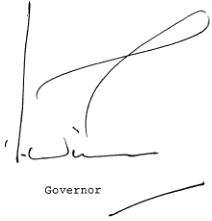

正在匹配文本
待匹配文本列表
0:  The Faculty of Engineering of the University of Hong Kong has played an important role not only in the University's history, but also in the history of the development of our industrial sector. When the Faculty of Engineering was first established in l9l2, Hong Kong's industry was virtually non-existent. Since then, the Engineering Faculty has expanded substantially, keeping pace throughout these years with the progress of technology in the world as well as with Hong Kong's dynamic industrial development.
1:  I congratulate the Faculty on its achievements. over the past seventy five years and send my best wishes for the future.
2:  MESSAGE FROM THE CHANCELLOR
3:  HIS EXCELLENCY SIR DAVID WILSON, KCMG
文本: ' MESSAGE FROM THE CHANCELLOR' 的匹配概率: 0.9066
正在处理: 75YearsofEngineering_110_3


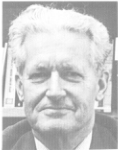

正在匹配文本
待匹配文本列表
0:  Lcquenl industria engineering, how do you define it and what will you teach? The three. of us, Dr. Chen, Dr. Niem, and I discussed what the scope of the department should be; we felt that production. engineering, as understood in the UK, was too narrow in scope and that the definition used by the American Institute of Industrial Engineers was more helpful. Briefly this defines I.E. as the academic and professional studies of the organization of men, machines, materials, and money, in both manufacturing and serviceindustries. It may thus  be thought of as man-centred systems engineering" and although the  main applications have been (and still are) in manufacturing industry, the concepts and
1:  The University had been endeavouring to appoint its first Professor of Industrial Engineering for some years prior to 1973 when it again advertised, this time for both a Professor and a Senior Lecturer. In the event, no appointment of a Professor was made and the writer was ap

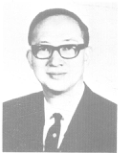

正在匹配文本
待匹配文本列表
0:  Fifty years ago the University as a third year electrical engineering student. At that time our engineering degree courses followed closely those of the University of London. In order to gain recognition from overseas institutions, our honours B.Sc.(Eng.) degrees were examined by London assessors who were mostly professors at the. ImperialCollege, London. Compared with the present day faculty strength, our Engineering Faculty in the pre-war years was very small. There was one professor each in the Departments of Civil, Electrical and Mechanical Engineering. Each Department had a few lecturers and. demonstrators. Sometimes we invited engineers outside the University to give lectures on a part-time basis.  Though our Faculty was small, our electrical and mechanical engineering degrees were recognized by their respective professional institutions in England for full exemption from the institution examinations. Our professor of civil engineering Professor F.A. Redmond, w

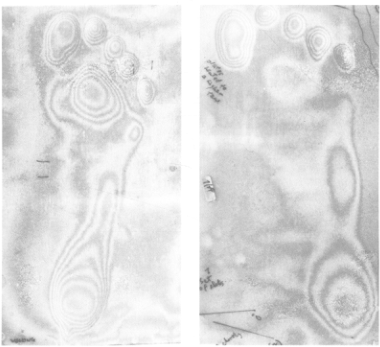

正在匹配文本
待匹配文本列表
0:  A study was undertaken, in  collaboration with and supported by the Department of Orthopaedics of HKU, to devise a simple method for foot pressure measurement. The shadow-moire method was used to map depth contours of a foot imprint made on a polystyrene sheet. A calibration curve related the applied pressure to the depth of imprint. and was used to transform the depth contours to pressure contours.. The figures below show  some characteristic pictures obtained. The one on the left is a time integrated footprint during a walking step while the
1:  A.Asundi
2:  PEDEMOIROGRAPHY
文本: ' A study was undertaken, in  collaboration with and supported by the Department of Orthopaedics of HKU, to devise a simple method for foot pressure measurement. The shadow-moire method was used to map depth contours of a foot imprint made on a polystyrene sheet. A calibration curve related the applied pressure to the depth of imprint. and was used to transform the depth contours to pressure

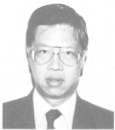

正在匹配文本
待匹配文本列表
0:  could not deny the influence of my father's profession and his successful lifelong career as an electrical engineer on my going deliberate intention of not following my for engineering studies, but. my fathers footsteps kept me from electrical engineering. My genuine mechanical engineering
1:  Inthose regarded the elite and the envy of friends and relatives fell uninvited upon anyone who successfully gained admission to this prestigious  institution, 1I was not uncommon to have the following stereotyped conversation in every social gathering:
2:  affiliation to the Faculty of Engineering dates back 1939 when m fatherbecame an. electrical engineering graduate of the University of Hong Kong. blessed association was furtheredin 1964with my own enrolment for the B.Sc.(Eng.) curriculum, and in 1982-83 with Presidency of the HKU Engineering Alumni Association, thef first electrical or  mechanical graduate in the position.
3:  DAYS IN THE DEPARTMENT OF MECHANICAL ENGINEERIN

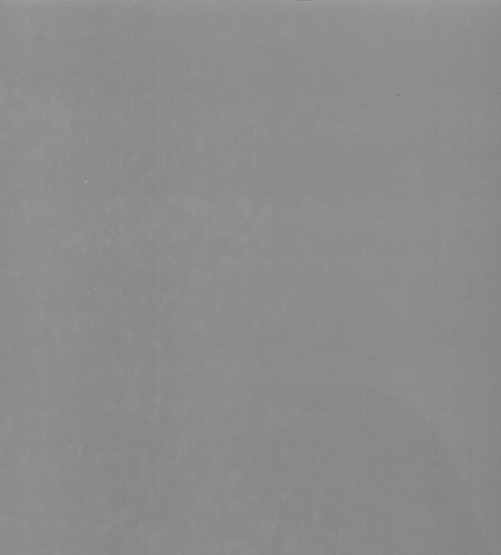

正在处理: 75YearsofEngineering_93_5


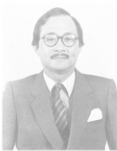

正在匹配文本
待匹配文本列表
0:  At that time, Hong Kong was just beginning emergeas manufacturing and trading centre. I looked around me and found the Hong Kong skyline constantly being changed by buildings, roads being. built, reservoirs being excavated, and power plants being erected. I saw myself contributing to this infrastructural development, participating in the growing sophistication of Hong Kong which would ultimately. differentiate it from being "just another city in the world". Engineering seemed to be the answer, and indeed that was what I decided upon when I applied to the.
1:  fact am UE enginee professior not matter O coincidence mucD GoIDSUOD JCCIS1OD last-few would like to De Like orofessional tennis player with travelling the world. But deep down these were grandiose ideas, as none of them matched my ambition of making a tangible contribution to the society to which I belonged.
2:  LevelMatriculatior Examination Being onsidered not only an honour but a stroke of luck in
3:  ricul 

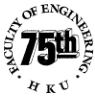

正在匹配文本
待匹配文本列表
0:  75th Anniversary nemorative Publicat
1:  Faculty of Engineering University of Hong Kong
2:  75 Years of Engineering
3:  75 Years of Engineering
文本: ' Faculty of Engineering University of Hong Kong' 的匹配概率: 0.3641
正在处理: 75YearsofEngineering_88_7


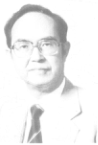

正在匹配文本
待匹配文本列表
0:  It all started on a hot summer afternoon in 1952 when I walked into an optician's shop. Before that time, I always planned to study science at theUniversity. In my secondary school days, I was very good at mathematics and I took readily to physics and chemistry, so it was natural that I aspired to becoming a scientist in the future. Nevertheless when I walked out of the optician's shop, I felt that I had. better change my plan because the optician gave me a free consultation and found out that I was weak in distinguishing the colours red and. green (though I was by no means colour-blind). I thought that this weakness might be a hindrance to my further study in science. The one course open to me in which I could use my mathematics would be to join the Engineering Faculty. At that time the Engineering Faculty  L became a civil engineer
1:  mainly preliminary science. Therefore most of my time was spent in the large lecture theatre of the Northcote Science Building by P

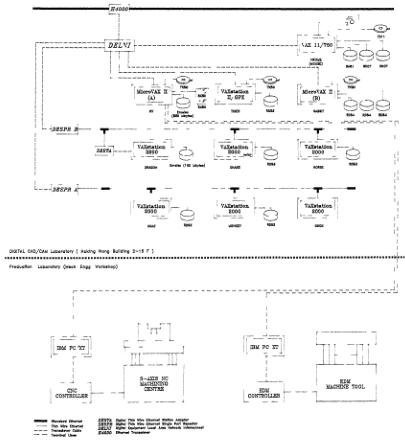

正在匹配文本
待匹配文本列表
0:  Computing and Machining Hardwar
文本: ' Computing and Machining Hardwar' 的匹配概率: 1.0000
正在处理: 75YearsofEngineering_299_3


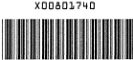

正在匹配文本
待匹配文本列表
0:  B620.0071105
文本: ' B620.0071105' 的匹配概率: 1.0000
正在处理: 75YearsofEngineering_2_5


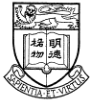

正在匹配文本
待匹配文本列表
0:  75th Anniversary nemorative Publicat
1:  Faculty of Engineering University of Hong Kong
2:  75 Years of Engineering
3:  75 Years of Engineering
文本: ' Faculty of Engineering University of Hong Kong' 的匹配概率: 0.9911
正在处理: 75YearsofEngineering_190_5


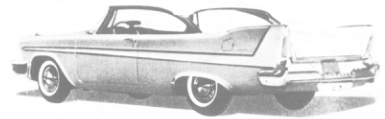

正在匹配文本
待匹配文本列表
0:  The shape cars is determined by economics, fashion, and the technological capabilities of fabricators and the materials used. After 1950 sheet steel press performance was improved and very complex shapes could be made easily and cheaply. This is an example of tailoring the properties of materials to meet the requirements of the designer
1:  Ford car circa 1959
文本: ' Ford car circa 1959' 的匹配概率: 0.7190
正在处理: 75YearsofEngineering_166_4


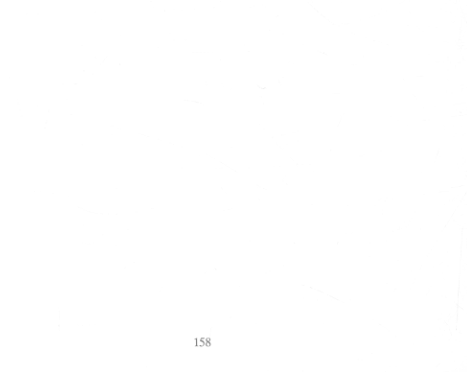

正在匹配文本
待匹配文本列表
0:  ecomin nothe energ crisis is approaching and j rea University engaging in part of a otential for having such a major impact on the velfare tur nerations
文本: ' ecomin nothe energ crisis is approaching and j rea University engaging in part of a otential for having such a major impact on the velfare tur nerations' 的匹配概率: 1.0000
正在处理: 75YearsofEngineering_1_0


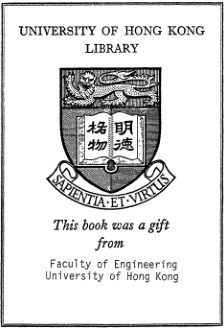

正在处理: 75YearsofEngineering_0_0


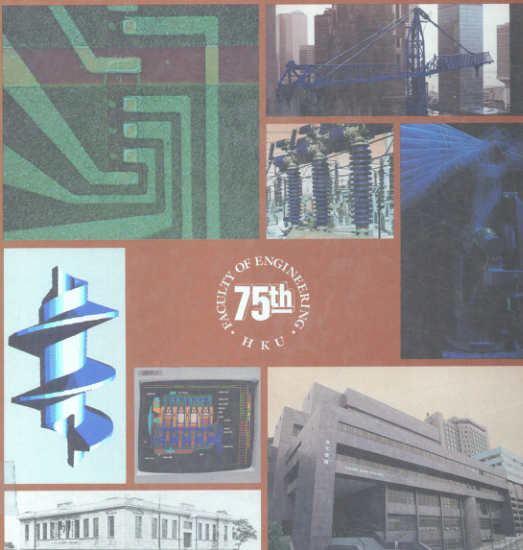

正在匹配文本
待匹配文本列表
0:  75 Years of Engineering
1:  75 Years of Engineering
文本: ' 75 Years of Engineering' 的匹配概率: 0.5000
正在处理: 75YearsofEngineering_17_0


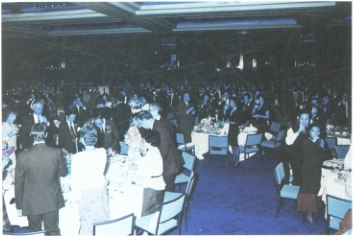

正在匹配文本
待匹配文本列表
0:  Below: Alumni, guests, and staff respond to the toast.
1:  Gungwu -Chancellor) proposes Faculty
文本: ' Below: Alumni, guests, and staff respond to the toast.' 的匹配概率: 0.9957
正在处理: 75YearsofEngineering_100_7


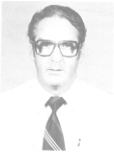

正在匹配文本
待匹配文本列表
0:   Of the course selection committee, and Im sure it of expertise, then they were very successful. The course commenced with fifteen students all of whom had appropriate experience in the industrial engineering field and all were able to make a valuable contribution to the. course. They came from both the private and public working sectors of. Hong Kong and their work experience covered a wide variety of industrial activities. Some members of the group ran their own businesses and were employer, whilst there were those who were on the verge of giving up their employment and starting their own business. Other members of the group. were from the educational field, like myself, or had spent their whole working life in local industry.
1:  The course also proved to be interesting and different in other ways. The staff, for example, encouraged student participation much more than I had experienced in other courses of study, even going so far as to allowing the students to gi

In [ ]:
from colorama import Fore
from IPython.display import display
import nltk
from nltk.tokenize import sent_tokenize

image_ids = list(set(df["id_x"].tolist()))

results = []
for image_id in image_ids:
    image_array = df_figures[df_figures["id"] == image_id]["image_array"].item()
    image = Image.fromarray(image_array)
    # 定义要匹配的文本列表

    text_ids = df[df["id_x"] == image_id]["id_y"]
    # texts = df_ocr[df_ocr["id"].isin(text_ids)]["ocr_text"].dropna().tolist()
    texts_pre = df_ocr[df_ocr["id"].isin(text_ids)]["ocr_text"].dropna().tolist()

    texts = []
    for text in texts_pre:
        if text == "":
            continue
        texts.append(text)
        # if len(text.split(". ")) > 1:
        #     sentences = sent_tokenize(text)
        #     texts.extend(sentences)
        # else:
        #     texts.append(text)

    print(f"正在处理: {image_id}")
    display(image)
    # 生成文本

    if len(texts) == 0:
        print("没有待匹配文本, 生成Caption中")
        caption = generate_caption(image)[0]

        results.append({
            "image_id": image_id,
            "image_array": image_array,
            "text": caption,
            "type": "GENERATE"
        })
        print(Fore.GREEN + "生成结果: " + caption + Fore.RESET)

        continue

    # 匹配文本
    else:
        print("正在匹配文本")
        print("待匹配文本列表")
        for idx, text in enumerate(texts):
            print(f"{idx}: {text}")

        match_text, match_prob = match_caption(texts, image)

        print(Fore.CYAN + f"文本: '{match_text}' 的匹配概率: {match_prob:.4f}" + Fore.RESET)

        results.append({
            "image_id": image_id,
            "image_array": image_array,
            "text": match_text,
            "type": "MATCHED"
        })


results_df = pd.DataFrame(results)

In [13]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_id     18 non-null     object
 1   image_array  18 non-null     object
 2   text         18 non-null     object
 3   type         18 non-null     object
dtypes: object(4)
memory usage: 704.0+ bytes


In [ ]:
results_temp = {
    "1": 123,
    "234": 12314,
    "hello": "asfa"
}

In [14]:
file_name

'75YearsofEngineering'

In [15]:
results_df.to_pickle(f"results/{file_name}_unmatched_caps.pkl")

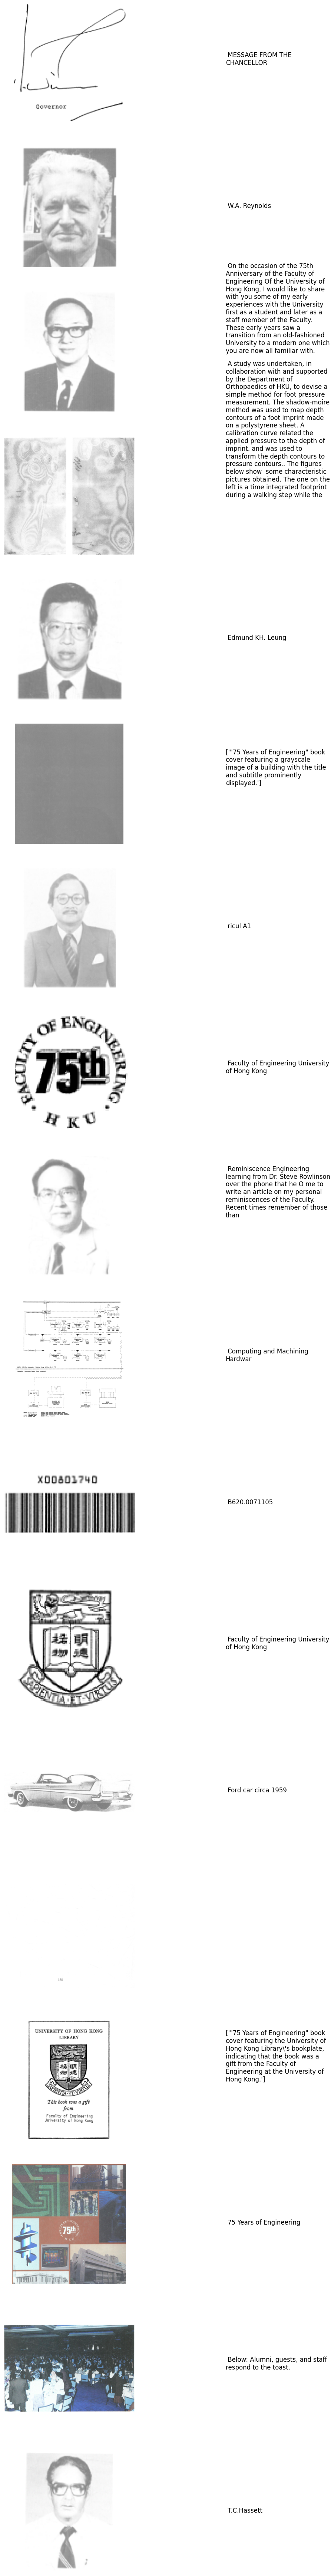

In [38]:
import matplotlib.pyplot as plt
images = results_df["image_array"].tolist()
texts = results_df["text"].tolist()

fig, axes = plt.subplots(len(images), 2, figsize=(10, 5 * len(images)))

for ax in axes.flatten():
    ax.axis("off")

for idx, ax in enumerate(range(len(axes))):
    axes[idx][0].imshow(images[idx])
    axes[idx][1].text(0.5, 0.5, texts[idx], fontsize=12, wrap=True)

'75YearsofEngineering_77_3'

In [43]:
df_bbs[df_bbs["id"] == results_df.iloc[2]["image_id"]]

,id,page,xyxy,image_array,type,type_str,type_conf
489,75YearsofEngineering_77_3,77,"[[345.3203125, 52.15256881713867, 463.82458496...","[[[255, 255, 255], [255, 255, 255], [255, 255,...",3,figure,0.785648
